In [ ]:
from matplotlib import pyplot as plt
import skimage as ski
import numpy as np
from skimage import io


PATH = '/content/drive/MyDrive/123OfAi/word_images_normalized'
PADDED_PATH = "/content/drive/MyDrive/123OfAi/padded_images"
GROUND_TRUTH_FILE = "/content/drive/MyDrive/123OfAi/word_labels.txt"
RESIZED_PADDED_PATH ="/content/drive/MyDrive/123OfAi/resized_padded_images"

is_padded = False
is_resized = False

## **Section 1 : Utils**



1.   **get_max_rows_cols** : gets max rows and columns across all dataset

2.   **pad_images**:
appends 0 to make all images of same size wrt max_col and max_rows

3.   **resize_images**
resizes the padded images to 25% of their original size

4.   **prepare_gtruth:**
preprocessing of the input labels

5.   **flatten_image:**
flattens the 2D image to 1D

6. **perform_quant_analysis:**
calculates accuracy score

7. **visualize_neighbours:**
plots graph for kNN





In [ ]:
def get_max_rows_cols():
  import os

  max_rows = 0
  max_cols = 0
  max_rows_image_path = ''
  max_cols_image_path = ''

  # Iterate through the images in the folder
  for filename in os.listdir(PATH):
      if filename.endswith(('.png')):  # Add more image extensions if needed
          image_path = PATH+ "/"+filename;
          # Read the image
          image = io.imread(image_path)
          # Get the dimensions of the current image
          rows, cols = image.shape  # Assuming color images

          # Update max dimensions if current image is larger
          if rows > max_rows :
              max_rows = rows
              max_rows_image_path = image_path

          if cols > max_cols:
              max_cols = cols
              max_cols_image_path = image_path

  # Print the information about the image with the largest dimensions
  print(f"Image with the largest dimensions:")
  print(f"R Path: {max_rows_image_path}")
  print(f"C Path: {max_cols_image_path}")
  print(f"Rows: {max_rows}")
  print(f"Columns: {max_cols}")
  return max_rows, max_cols

In [ ]:
import warnings
import os
from PIL import Image

#  Pad the existing images with make it in sync with largest row and column value across the dataset
#  Save the images afetr padding at PADDED_PATH location
def pad_images():
  target_rows, target_cols = get_max_rows_cols()
  # target_rows, target_cols = 120, 645

  for filename in os.listdir(PATH):
      if filename.endswith(('.png')):
        image_path = PATH+ "/"+filename;
        # Read the image
        image = io.imread(image_path)
        pad_cols = max(0, target_cols - image.shape[1])
        padded_image = np.pad(image, ((0, 0), (0, pad_cols)), constant_values=True)
        with warnings.catch_warnings():
          warnings.simplefilter("ignore")
          io.imsave(PADDED_PATH+"/"+filename, padded_image.astype(bool))


def resize_images():
  scaling_factor = 0.25
  for filename in os.listdir(PADDED_PATH):
    if filename.endswith(('.png')):
      image_path = PADDED_PATH+ "/"+filename;
      image =  Image.open(image_path)
      new_width = int(image.width * scaling_factor)
      new_height = int(image.height * scaling_factor)
      resized_image = image.resize((new_width, new_height))
      resized_image.save(RESIZED_PADDED_PATH+"/"+filename)

if is_padded==False:
  pad_images

if is_resized==False:
  resize_images()

In [ ]:

import re

# Parse and cleanup the ground truth data to extract the word.
# Stores the cleaned data in gtruth_dictionary

def extract_word(text):
    parts = text.split('_')
    return parts[0].replace('-', '')

def cleanup_word(text):
   return text.replace("s_cm",",").replace("s_pt",".")

def prepare_gtruth():
  gtruth_dict = {};
  with open(GROUND_TRUTH_FILE, 'r') as file:
    lines = file.readlines()
    for line in lines:
        file_name, word = line.strip().split(' ', 1)
        word = cleanup_word(word)
        match = re.search(r'\d+', word)
        result_value = ''.join(re.findall(r'\d', word)) if match else extract_word(word)
        gtruth_dict[file_name]= result_value;
  return gtruth_dict

In [ ]:
import os

# create 1D arrayof each image and append to padded_img_arr
# retrun both flattened as well original image tuple
def flatten_image():
  padded_img_arr = []
  ori_img_arr = []
  for filename in os.listdir(RESIZED_PADDED_PATH):
        if filename.endswith(('.png')):
          image_path = RESIZED_PADDED_PATH+ "/"+filename;
          image = io.imread(image_path)
          ori_img_arr.append(image)
          padded_img_arr.append(image.flatten())
  return (padded_img_arr, ori_img_arr)

In [ ]:
from tabulate import tabulate

def prepare_results(y_train, y_test, indices):
  result_data = []
  for i,neighbors_indices in enumerate(indices):
    result_data.append({"word":y_test[i],"nearestIndex":list(neighbors_indices),"nearestWords":[y_train[i] for i in neighbors_indices.flatten()]})
  return result_data

def print_results(result_data):
  headers = result_data[0].keys()
  table_data = [(entry['word'], entry['nearestIndex'], entry['nearestWords']) for entry in result_data]
  table = tabulate(table_data, headers, tablefmt="pretty")
  print(table)

# prepare_results()
# print_results()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


def perform_quant_anlysis(y_test,result_data):
  # words = [item['word'] for item in result_data]
  neighbours = [item['nearestWords'] for item in result_data]

  y_pred_flat = [item[0] for item in neighbours]
  accuracy = accuracy_score(y_test, y_pred_flat)
  precision = precision_score(y_test, y_pred_flat, average='micro')
  recall = recall_score(y_test, y_pred_flat, average='micro')
  f1 = f1_score(y_test, y_pred_flat,  average='micro')
  conf_matrix = confusion_matrix(y_test, y_pred_flat)

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)
# print("Confusion Matrix:\n", conf_matrix)


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.animation import FuncAnimation


def visualize_neighbours(y_train,y_test,indices,k):
  G = nx.Graph()

  for i in y_test[:k]:
      if not G.has_node(i):
        G.add_node(i)

  for i,neighbors_indices in enumerate(indices[:k]):
    neighbours = [y_train[j] for j in neighbors_indices.flatten()]
    for j in neighbours:
      if not G.has_node(j):
        G.add_node(j)

  for i in range(k):
    neighbours = [y_train[j] for j in indices[i].flatten()]
    # print(neighbours)
    for j in  range(len(neighbours)):
      G.add_edge(y_test[i], neighbours[j])

  pos = nx.spring_layout(G)
  nx.draw(G, pos, with_labels=True, node_size=300, node_color='lightgreen', font_size=7, font_color='black', edge_color='black', width=1.0)
  plt.title('Nearest Neighbors Graph')
  plt.show()


## **Section 2 : Model Evaluation**



1.   **NearestNeighbour**
2.   **Using Variable Feature Length**
3.  **scikitlearn-image HOG**
3.  **scikitlearn-image LBP**



In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.neighbors import NearestNeighbors


def find_nearest_neighbour(k, X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  X_train = np.array(X_train)
  nn_model = NearestNeighbors(metric='cosine', algorithm='brute')
  nn_model.fit(X_train)

  X_test = np.array(X_test)
  distances, indices = nn_model.kneighbors(X_test, n_neighbors=k)
  return (y_train, y_test,distances, indices)


**Find the nearest neighbors and analyze the results**

In [ ]:
gtruth_dict = prepare_gtruth();
padded_flattened_img_arr, ori_img_array = flatten_image();
kNeighbours = 3
y_train, y_test,distances, indices = find_nearest_neighbour(kNeighbours, padded_flattened_img_arr, list(gtruth_dict.values()))
result_data = prepare_results(y_train, y_test, indices)
# # print_results(result_data)
perform_quant_anlysis(y_test,result_data)

Accuracy: 0.013278855975485188
Precision: 0.013278855975485188
Recall: 0.013278855975485188
F1 Score: 0.013278855975485188


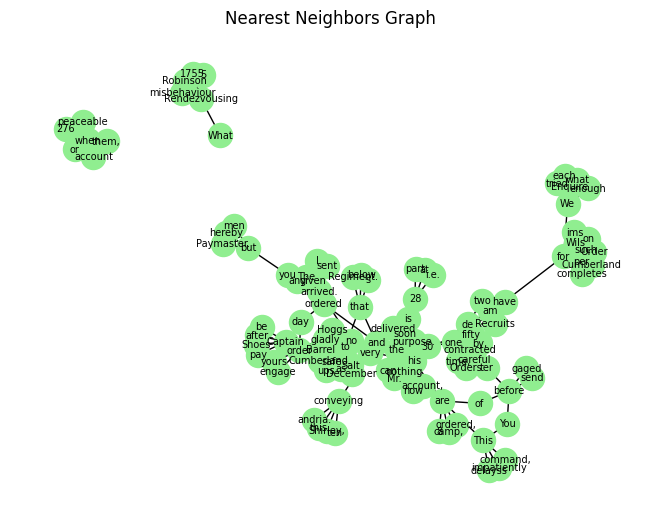

In [ ]:
visualize_neighbours(y_train,y_test,indices,25)

**Using Variable Feature Length**

In [ ]:
# Create feature vector by combining all the features below
# Feature 1: Sum of ones per column
# Feature 2: First occurrence of 1 when scanning from top to bottom
# Feature 3: First occurrence of 1 when scanning from bottom to top
# Feature 4: First occurrence of 1 when scanning from left to right
# Feature 5: First occurrence of 1 when scanning from right to left

def add_features(binary_images):
    features = []
    for img in binary_images:
        binary_image = (img > 0).astype(int)
        column_sum_1s = np.sum(binary_image, axis=0)
        first_occurrence_top_to_bottom = np.argmax(img, axis=0)
        first_occurrence_bottom_to_top = img.shape[0] - 1 - np.argmax(np.flipud(img), axis=0)
        first_occurrence_left_to_right = np.argmax(binary_image == 1, axis=0)
        first_occurrence_right_to_left = binary_image.shape[1] - 1 - np.argmax(binary_image[:, ::-1] == 1, axis=0)
        combined_feature = np.concatenate([column_sum_1s, first_occurrence_top_to_bottom,
                                           first_occurrence_bottom_to_top,first_occurrence_left_to_right.flatten(),first_occurrence_right_to_left.flatten()])
        features.append(combined_feature)
    return np.array(features)

In [ ]:
# padded_flattened_img_arr, ori_img_array = flatten_image();

In [ ]:
kNeighbours = 3
feature_array = add_features(ori_img_array)

y_train, y_test,distances, indices = find_nearest_neighbour(kNeighbours, feature_array, list(gtruth_dict.values()))
result_data = prepare_results(y_train, y_test, indices)
# print_results(result_data)
perform_quant_anlysis(y_test,result_data)


Accuracy: 0.008171603677221655
Precision: 0.008171603677221655
Recall: 0.008171603677221655
F1 Score: 0.008171603677221655


**Feature extraction with scikitlearn-image**

In [ ]:

from skimage.feature import hog
from skimage import exposure
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Feature extraction using HOG
def extract_hog_features(images):
    hog_features = []
    for image in images:
        fd, _ = hog(image, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualize=True)
        hog_features.append(fd)
    return hog_features

def analyze_with_HOG():
  X = ori_img_array
  y = list(gtruth_dict.values())
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  X_train_hog = extract_hog_features(X_train)
  X_test_hog = extract_hog_features(X_test)

  clf = SVC()
  clf.fit(X_train_hog, y_train)
  y_pred = clf.predict(X_test_hog)
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {accuracy}")

analyze_with_HOG()

Accuracy: 0.04187946884576098


In [ ]:
from skimage import io, feature, color
import numpy as np

def analyze_with_LBP():
  features = []
  for filename in os.listdir(RESIZED_PADDED_PATH):
          if filename.endswith(('.png')):
            image_path = RESIZED_PADDED_PATH+ "/"+filename;
            image = io.imread(image_path)
            lbp_features = feature.local_binary_pattern(image, P=8, R=1, method='uniform')
            flat_lbp_features = lbp_features.flatten()
            features.append(flat_lbp_features)

  X = np.array(features)
  y = list(gtruth_dict.values())


  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  svc_model = SVC()
  svc_model.fit(X_train, y_train)
  y_pred = svc_model.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {accuracy}")

analyze_with_LBP()

Accuracy: 0.04187946884576098
